# Notebook for ANNDL - Homework 1

Team: All Is Well

Team members: Fatma Hamila, Kodai Takigawa, Zheng Maria Yu

# Setup
Firstly, we need to setup the environment by importing the required libraries, setting the current path (eventually mounting Google Drive), and fixing the random seed for our experiments' reproducibility.

The dataset should be present in the same folder of this notebook.

In [1]:
# Import libraries
import tensorflow as tf
import numpy as np
import os
import random

tfk = tf.keras
tfkl = tf.keras.layers

In [2]:
use_drive = False

In [3]:
# Connect to Google Drive
# Set path

if(use_drive):
    from google.colab import drive
    drive.mount('/gdrive')
    path = "/gdrive/My Drive/ANNDL/2022-23/Homework1"
    %cd /gdrive/My Drive/ANNDL/2022-23/Homework1
else:
    path = os.getcwd()
    print(str(path))

C:\Users\zheng\Documents\Uni\Magistrale\ANNDL\22-23\Homework1\Env


In [4]:
# Fix random seed for reproducibility
seed = 23

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Data splitting
Now the dataset file should be unzipped and split into two parts: a training folder and a validation folder.

Two data splitting modes are provided here:
- make a random split using the package split-folders,
- make a regular split using the function we defined below.

In [5]:
# Set to True to use the random seed for data splitting
random_split = True

In [6]:
# Set to True if we want to split the dataset folder
split_dataset = False

In [7]:
# Handle the dataset splitting
# Random split: the operation is based on the chosen random seed
# Regular split: the operation selects a validation sample per n images (current: n=20)

if(split_dataset):
    
    # Unzip the dataset file
    !unzip dataset.zip
    
    # Import the splitfolders funtion for random splitting
    if(random_split):
        !pip install split-folders
        import splitfolders
        
        splitfolders.ratio("training", output="output", seed=seed, ratio=(.8, .2), group_prefix=None)
        print("Random split completed")
    
    else:
        import glob
        import shutil
    
        path = path + "/dataset"
        os.chdir(path)
        cwd = os.getcwd()
        cwd
    
        os.makedirs("validation", exist_ok=True)
    
        i = 0
        n = 20
    
        for file in glob.glob("training/*/*.jpg", recursive=True):
            if i == n:
                old_path = os.path.join(cwd, str(file))
                new_path = old_path.replace("training", "validation")
                print("Image: " + new_path)
            
                if not os.path.exists(os.path.dirname(new_path)):
                    os.makedirs(os.path.dirname(new_path), exist_ok=True)
            
                shutil.move(old_path, new_path)
                i = 0
                continue
            i += 1
        print("Regular split completed")

In [8]:
# Set working paths

if(random_split):
    data_dir = os.path.join(path, 'dataset')
    dataset_dir = os.path.join(data_dir, 'output')
    training_dir = os.path.join(dataset_dir, 'train')
    validation_dir = os.path.join(dataset_dir, 'val')

else:
    dataset_dir = cwd
    training_dir = os.path.join(dataset_dir, 'training')
    validation_dir = os.path.join(dataset_dir, 'validation')

# Mode selection
There are different available options for the model: it can be a basic convolutional neural network or based on a pre-trained one.

The pre-trained models that we tried out are MobileNetV2, ResNet50V2, VGG19, EfficientNetB7.

In transfer learning mode, the parameters of the supernet are freezed temporarily.

In [9]:
# Params: [Baseline, Mobilenet, Resnet, VGG, Efficientnet, EfficientnetV2]
mode = 'EfficientnetV2'

# Data pre-processing
In this part, data preprocessing is done with the corresponding preprocessing function or with the rescale factor.

Data augmentation options are also available.

In [10]:
# Import the correct preprocessing function for pre-trained models
if mode == 'EfficientnetV2':
    from tensorflow.keras.applications.efficientnet_v2 import preprocess_input

In [11]:
# Set batch size
batch_size = 64

In [12]:
# Set to True to apply data augmentation methods
data_augmentation = True

In [13]:
# Load data with ImageDataGenerator
# Other available parameters: width_shift_range = 0.2, height_shift_range = 0.2, zoom_range = 0.15, rotation_range = 20

from tensorflow.keras.preprocessing.image import ImageDataGenerator


if(mode == 'Baseline'):
    train_data_gen = ImageDataGenerator(
        rescale = 1/255.
    )
        
    val_data_gen = ImageDataGenerator(
        rescale = 1/255.
    )
    
    print("Rescaling completed")
    
else:
    train_data_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input)
    
    val_data_gen = ImageDataGenerator(
        preprocessing_function = preprocess_input
    )
        
    print("Preprocessing function applied")

Preprocessing function applied


In [14]:
# Create iterators
train_gen = train_data_gen.flow_from_directory(
    directory = training_dir,
    target_size = (96,96),
    color_mode = 'rgb',
    classes = None,
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True,
    seed = seed
)

val_gen = val_data_gen.flow_from_directory(
    directory = validation_dir,
    target_size = (96,96),
    color_mode = 'rgb',
    classes = None,
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = False,
    seed = seed
)

Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


In [15]:
# Define augmented images generator

import albumentations as alb
from tensorflow.keras.utils import Sequence

class AugmentDataGenerator(Sequence):
    def __init__(self, datagen, augment=None):
        self.datagen = datagen
        if augment is None:
            self.augment = alb.Compose([])
        else:
            self.augment = augment
    
    def __len__(self):
        return len(self.datagen)
    
    def __getitem__(self, x):
        images, *rest = self.datagen[x]
        augmented = []
        for image in images:
            image = self.augment(image=image)['image']
            augmented.append(image)
        return (np.array(augmented), *rest)

In [16]:
if(data_augmentation):
    train_gen = AugmentDataGenerator(train_gen, alb.Compose([
        alb.OneOf([
            alb.HorizontalFlip(),
            alb.VerticalFlip()
        ]),
        alb.Transpose(),
        alb.GaussNoise(),
        alb.CoarseDropout(),
        alb.RandomBrightnessContrast(),
        alb.SafeRotate(limit=20),
        alb.OneOf([
            alb.OpticalDistortion(),
            alb.GridDistortion()
        ], p=0.3)
    ]))
    
    print("Data augmentation applied")

Data augmentation applied


# Hyperparameters setting
In this part, the hyperparameters of the model are defining.

In [17]:
# Fix input shape and number of epochs
input_shape = (96, 96, 3)
epochs = 1000

In [18]:
# Define the categorical focal loss
from keras import backend as K

def categorical_focal_loss(y_true, y_pred):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """
    
    alpha = [[.25, .1, .1, .1, .1, .1, .1, .15]]

    alpha = np.array(alpha, dtype=np.float32)
    
    gamma = 2.

    """
    :param y_true: A tensor of the same shape as `y_pred`
    :param y_pred: A tensor resulting from a softmax
    :return: Output tensor.
    """

    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

    # Calculate Cross Entropy
    cross_entropy = -y_true * K.log(y_pred)

    # Calculate Focal Loss
    c_loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

    # Compute mean loss in mini_batch
    return K.mean(K.sum(c_loss, axis=-1))

In [19]:
# Define loss
loss = tfk.losses.CategoricalCrossentropy()
# loss = categorical_focal_loss

# Define learning rate
lr = 1e-3

# Define optimizer for regularization
optimizer = tfk.optimizers.Adam(learning_rate = lr, epsilon = 0.1)

# Define metrics for evaluation
metrics = ['accuracy']

In [20]:
# !pip install tensorflow_addons

In [21]:
# import tensorflow_addons as tfa

# optimizer = tfa.optimizers.AdamW(weight_decay=1e-5, learning_rate=lr, epsilon=0.1)

# Model structure
According to the chosen mode, the corresponding model structure is loaded.

## Basic CNN model

In [22]:
# Use base CNN model
if(mode == 'Baseline'):
    model = tfk.Sequential()
    
    # Input layer
    model.add(tfkl.Input(shape=input_shape, name='Input'))

    # Convolution + Pooling
    model.add(tfkl.Conv2D(
        filters=32,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

    model.add(tfkl.Conv2D(
        filters=64,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

    model.add(tfkl.Conv2D(
        filters=128,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfkl.Conv2D(
        filters=256,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))
    
    model.add(tfkl.Conv2D(
        filters=512,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    model.add(tfkl.BatchNormalization())
    model.add(tfkl.MaxPooling2D(pool_size=(2, 2)))

    
    # Flatten
    model.add(tfkl.Flatten(name='Flatten'))

    
    # Linear layer with ReLU activation
    model.add(tfkl.Dense(
        units=128,
        activation='relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)
    ))
    
    # Dropout layer
    model.add(tfkl.Dropout(0.2, seed=seed))

    # Output layer
    model.add(tfkl.Dense(
        units=8,
        activation='softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name='Output'
    ))

## Supernet: EfficientNetV2B0

In [26]:
if(mode == 'EfficientnetV2'):
    supernet = tfk.applications.EfficientNetV2B0(
        include_top = False,
        weights = "imagenet",
        input_shape = (224, 224, 3)
    )
#     supernet.trainable = True
    
    model = tf.keras.Sequential()
    model.add(tfkl.Input(shape=input_shape, name='Input'))
    model.add(tfkl.Resizing(height=224, width=224))
    model.add(supernet)
    model.add(tfkl.GlobalAveragePooling2D())
    
    model.add(tfkl.Dense(
        units = 128,
        activation = 'relu',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))
    
    model.add(tfkl.Dense(
        units = 8,
        activation = 'softmax',
        kernel_initializer = tfk.initializers.GlorotUniform(seed)))

## Model summary and compilation

In [27]:
if(mode != 'Baseline'):
    supernet.summary()

Model: "efficientnetv2-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['normalization[0

                                                                                                  
 block3b_project_conv (Conv2D)  (None, 28, 28, 48)   9216        ['block3b_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 block3b_project_bn (BatchNorma  (None, 28, 28, 48)  192         ['block3b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block3b_drop (Dropout)         (None, 28, 28, 48)   0           ['block3b_project_bn[0][0]']     
                                                                                                  
 block3b_add (Add)              (None, 28, 28, 48)   0           ['block3b_drop[0][0]',           
          

                                                                  'block4a_project_bn[0][0]']     
                                                                                                  
 block4c_expand_conv (Conv2D)   (None, 14, 14, 384)  36864       ['block4b_add[0][0]']            
                                                                                                  
 block4c_expand_bn (BatchNormal  (None, 14, 14, 384)  1536       ['block4c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block4c_expand_activation (Act  (None, 14, 14, 384)  0          ['block4c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block4c_d

 block5b_dwconv2 (DepthwiseConv  (None, 14, 14, 672)  6048       ['block5b_expand_activation[0][0]
 2D)                                                             ']                               
                                                                                                  
 block5b_bn (BatchNormalization  (None, 14, 14, 672)  2688       ['block5b_dwconv2[0][0]']        
 )                                                                                                
                                                                                                  
 block5b_activation (Activation  (None, 14, 14, 672)  0          ['block5b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5b_se_squeeze (GlobalAver  (None, 672)         0           ['block5b_activation[0][0]']     
 agePoolin

                                                                                                  
 block5d_activation (Activation  (None, 14, 14, 672)  0          ['block5d_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5d_se_squeeze (GlobalAver  (None, 672)         0           ['block5d_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5d_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block5d_se_squeeze[0][0]']     
                                                                                                  
 block5d_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5d_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6a_se_reshape (Reshape)   (None, 1, 1, 672)    0           ['block6a_se_squeeze[0][0]']     
                                                                                                  
 block6a_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block6a_se_reshape[0][0]']     
                                                                                                  
 block6a_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block6a_se_reduce[0][0]']      
                                                                                                  
 block6a_se_excite (Multiply)   (None, 7, 7, 672)    0           ['block6a_activation[0][0]',     
                                                                  'block6a_se_expand[0][0]']      
          

                                                                                                  
 block6c_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6c_se_excite[0][0]']      
                                                                                                  
 block6c_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6c_drop (Dropout)         (None, 7, 7, 192)    0           ['block6c_project_bn[0][0]']     
                                                                                                  
 block6c_add (Add)              (None, 7, 7, 192)    0           ['block6c_drop[0][0]',           
                                                                  'block6b_add[0][0]']            
          

                                                                                                  
 block6e_drop (Dropout)         (None, 7, 7, 192)    0           ['block6e_project_bn[0][0]']     
                                                                                                  
 block6e_add (Add)              (None, 7, 7, 192)    0           ['block6e_drop[0][0]',           
                                                                  'block6d_add[0][0]']            
                                                                                                  
 block6f_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6e_add[0][0]']            
                                                                                                  
 block6f_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6f_expand_conv[0][0]']    
 ization)                                                                                         
          

                                                                                                  
 block6h_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6g_add[0][0]']            
                                                                                                  
 block6h_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block6h_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block6h_expand_activation (Act  (None, 7, 7, 1152)  0           ['block6h_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block6h_dwconv2 (DepthwiseConv  (None, 7, 7, 1152)  10368       ['block6h_expand_activation[0][0]
 2D)      

In [28]:
# Show model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 8)                 1032      
                                                                 
Total params: 6,084,312
Trainable params: 6,023,704
Non-

In [29]:
# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics
)

# Checkpoint and Early stopping settings
Early stopping options can be activated to limit model overfitting.

There is possibility to save checkpoints during the training, in order to keep track of the performance and to get more choices of the final model.


In [30]:
os.getcwd()

'C:\\Users\\zheng\\Documents\\Uni\\Magistrale\\ANNDL\\22-23\\Homework1\\Env'

In [31]:
from datetime import datetime
def create_folders_and_callbacks(model_name):
    
    exps_dir = os.path.join('experiments')
    if not os.path.exists(exps_dir):
        os.makedirs(exps_dir)

    now = datetime.now().strftime('%b%d_%H-%M-%S')
    print(now)

    exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
    if not os.path.exists(exp_dir):
        os.makedirs(exp_dir)

    callbacks = []

    # Model checkpoint
    ckpt_dir = os.path.join(exp_dir, 'base_ckpts')
    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir)

    ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'),
                                                     save_weights_only=False, # True to save only weights
                                                     save_best_only=True,# True to save only the best epoch
                                                     monitor='val_accuracy')
    callbacks.append(ckpt_callback)

    # Visualize Learning on Tensorboard
    tb_dir = os.path.join(exp_dir, 'tb_logs')
    if not os.path.exists(tb_dir):
        os.makedirs(tb_dir)

    # By default shows losses and metrics for both training and validation
    tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
    callbacks.append(tb_callback)

    

    return callbacks, now

In [32]:
callbacks, date = create_folders_and_callbacks("EfficientnetV2B0")

Nov22_23-39-14


In [33]:
foldername = mode + '_' + str(date)
print(foldername)

EfficientnetV2_Nov22_23-39-14


In [35]:
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 200,
)

Epoch 1/200
45/45 [==============================] - 22s 263ms/step - loss: 2.0969 - accuracy: 0.1276 - val_loss: 2.0985 - val_accuracy: 0.1403
Epoch 2/200
45/45 [==============================] - 10s 217ms/step - loss: 2.0717 - accuracy: 0.1605 - val_loss: 2.0582 - val_accuracy: 0.1823
Epoch 3/200
45/45 [==============================] - 10s 224ms/step - loss: 2.0536 - accuracy: 0.1785 - val_loss: 2.0378 - val_accuracy: 0.1711
Epoch 4/200
45/45 [==============================] - 10s 222ms/step - loss: 2.0328 - accuracy: 0.1863 - val_loss: 2.0183 - val_accuracy: 0.1935
Epoch 5/200
45/45 [==============================] - 10s 221ms/step - loss: 2.0109 - accuracy: 0.2131 - val_loss: 1.9685 - val_accuracy: 0.2553
Epoch 6/200
45/45 [==============================] - 10s 218ms/step - loss: 1.9954 - accuracy: 0.2149 - val_loss: 1.9468 - val_accuracy: 0.2693
Epoch 7/200
45/45 [==============================] - 10s 226ms/step - loss: 1.9810 - accuracy: 0.2329 - val_loss: 1.9062 - val_accuracy:

45/45 [==============================] - 10s 215ms/step - loss: 1.3431 - accuracy: 0.5157 - val_loss: 0.5203 - val_accuracy: 0.8247
Epoch 114/200
45/45 [==============================] - 10s 215ms/step - loss: 1.3509 - accuracy: 0.5157 - val_loss: 0.5447 - val_accuracy: 0.8107
Epoch 115/200
45/45 [==============================] - 10s 215ms/step - loss: 1.3503 - accuracy: 0.5147 - val_loss: 0.5248 - val_accuracy: 0.8205
Epoch 116/200
45/45 [==============================] - 10s 216ms/step - loss: 1.3383 - accuracy: 0.5133 - val_loss: 0.5334 - val_accuracy: 0.8149
Epoch 117/200
45/45 [==============================] - 10s 215ms/step - loss: 1.3378 - accuracy: 0.5171 - val_loss: 0.5204 - val_accuracy: 0.8205
Epoch 118/200
45/45 [==============================] - 10s 216ms/step - loss: 1.3291 - accuracy: 0.5232 - val_loss: 0.5309 - val_accuracy: 0.8233
Epoch 119/200
45/45 [==============================] - 10s 216ms/step - loss: 1.3071 - accuracy: 0.5182 - val_loss: 0.5324 - val_accuracy:

In [36]:
history = model.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 800,
    callbacks = callbacks
).history

Epoch 1/800
45/45 [==============================] - ETA: 0s - loss: 1.1991 - accuracy: 0.5712

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_01.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_01.ckpt\assets


45/45 [==============================] - 62s 1s/step - loss: 1.1991 - accuracy: 0.5712 - val_loss: 0.4414 - val_accuracy: 0.8541
Epoch 2/800
45/45 [==============================] - 11s 246ms/step - loss: 1.1683 - accuracy: 0.5794 - val_loss: 0.4515 - val_accuracy: 0.8373
Epoch 3/800
45/45 [==============================] - 11s 246ms/step - loss: 1.1957 - accuracy: 0.5737 - val_loss: 0.4419 - val_accuracy: 0.8457
Epoch 4/800
45/45 [==============================] - 11s 246ms/step - loss: 1.1538 - accuracy: 0.5857 - val_loss: 0.4437 - val_accuracy: 0.8527
Epoch 5/800
45/45 [==============================] - ETA: 0s - loss: 1.1514 - accuracy: 0.5917

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_05.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_05.ckpt\assets


45/45 [==============================] - 60s 1s/step - loss: 1.1514 - accuracy: 0.5917 - val_loss: 0.4305 - val_accuracy: 0.8555
Epoch 6/800
45/45 [==============================] - ETA: 0s - loss: 1.1771 - accuracy: 0.5832

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_06.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_06.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.1771 - accuracy: 0.5832 - val_loss: 0.4291 - val_accuracy: 0.8597
Epoch 7/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1727 - accuracy: 0.5744 - val_loss: 0.4502 - val_accuracy: 0.8541
Epoch 8/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1707 - accuracy: 0.5748 - val_loss: 0.4543 - val_accuracy: 0.8443
Epoch 9/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1763 - accuracy: 0.5762 - val_loss: 0.4448 - val_accuracy: 0.8471
Epoch 10/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1506 - accuracy: 0.5903 - val_loss: 0.4559 - val_accuracy: 0.8499
Epoch 11/800
45/45 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.5885

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_11.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_11.ckpt\assets


45/45 [==============================] - 60s 1s/step - loss: 1.1385 - accuracy: 0.5885 - val_loss: 0.4171 - val_accuracy: 0.8626
Epoch 12/800
45/45 [==============================] - 12s 247ms/step - loss: 1.1677 - accuracy: 0.5811 - val_loss: 0.4271 - val_accuracy: 0.8612
Epoch 13/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1765 - accuracy: 0.5751 - val_loss: 0.4596 - val_accuracy: 0.8401
Epoch 14/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1883 - accuracy: 0.5755 - val_loss: 0.4472 - val_accuracy: 0.8387
Epoch 15/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1711 - accuracy: 0.5885 - val_loss: 0.4393 - val_accuracy: 0.8555
Epoch 16/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1256 - accuracy: 0.5935 - val_loss: 0.4262 - val_accuracy: 0.8569
Epoch 17/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1685 - accuracy: 0.5861 - val_loss: 0.4383 - val_accuracy: 0.8541
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_29.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_29.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.1613 - accuracy: 0.5850 - val_loss: 0.4063 - val_accuracy: 0.8668
Epoch 30/800
45/45 [==============================] - 12s 247ms/step - loss: 1.1523 - accuracy: 0.5914 - val_loss: 0.4180 - val_accuracy: 0.8612
Epoch 31/800
45/45 [==============================] - ETA: 0s - loss: 1.1643 - accuracy: 0.5829

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_31.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_31.ckpt\assets


45/45 [==============================] - 60s 1s/step - loss: 1.1643 - accuracy: 0.5829 - val_loss: 0.4026 - val_accuracy: 0.8724
Epoch 32/800
45/45 [==============================] - 12s 249ms/step - loss: 1.1341 - accuracy: 0.6030 - val_loss: 0.3978 - val_accuracy: 0.8654
Epoch 33/800
45/45 [==============================] - 11s 251ms/step - loss: 1.1447 - accuracy: 0.5900 - val_loss: 0.4069 - val_accuracy: 0.8668
Epoch 34/800
45/45 [==============================] - 11s 249ms/step - loss: 1.1407 - accuracy: 0.6009 - val_loss: 0.4037 - val_accuracy: 0.8668
Epoch 35/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1595 - accuracy: 0.5843 - val_loss: 0.4183 - val_accuracy: 0.8626
Epoch 36/800
45/45 [==============================] - 11s 249ms/step - loss: 1.1571 - accuracy: 0.5815 - val_loss: 0.4211 - val_accuracy: 0.8541
Epoch 37/800
45/45 [==============================] - 11s 249ms/step - loss: 1.1454 - accuracy: 0.5854 - val_loss: 0.3964 - val_accuracy: 0.8668
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_38.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_38.ckpt\assets


45/45 [==============================] - 62s 1s/step - loss: 1.1565 - accuracy: 0.5744 - val_loss: 0.3912 - val_accuracy: 0.8752
Epoch 39/800
45/45 [==============================] - 12s 248ms/step - loss: 1.1651 - accuracy: 0.5779 - val_loss: 0.4520 - val_accuracy: 0.8527
Epoch 40/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1413 - accuracy: 0.5931 - val_loss: 0.4205 - val_accuracy: 0.8640
Epoch 41/800
45/45 [==============================] - ETA: 0s - loss: 1.1545 - accuracy: 0.5829

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_41.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_41.ckpt\assets


45/45 [==============================] - 60s 1s/step - loss: 1.1545 - accuracy: 0.5829 - val_loss: 0.3913 - val_accuracy: 0.8794
Epoch 42/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1288 - accuracy: 0.6023 - val_loss: 0.4104 - val_accuracy: 0.8710
Epoch 43/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0942 - accuracy: 0.6214 - val_loss: 0.3983 - val_accuracy: 0.8752
Epoch 44/800
45/45 [==============================] - 11s 250ms/step - loss: 1.1388 - accuracy: 0.5868 - val_loss: 0.3994 - val_accuracy: 0.8766
Epoch 45/800
45/45 [==============================] - 11s 252ms/step - loss: 1.1219 - accuracy: 0.5924 - val_loss: 0.4095 - val_accuracy: 0.8640
Epoch 46/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1355 - accuracy: 0.5953 - val_loss: 0.3874 - val_accuracy: 0.8752
Epoch 47/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1006 - accuracy: 0.6013 - val_loss: 0.4145 - val_accuracy: 0.8668
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_63.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_63.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 1.1204 - accuracy: 0.5977 - val_loss: 0.3894 - val_accuracy: 0.8864
Epoch 64/800
45/45 [==============================] - 12s 248ms/step - loss: 1.0999 - accuracy: 0.6052 - val_loss: 0.3750 - val_accuracy: 0.8794
Epoch 65/800
45/45 [==============================] - 11s 247ms/step - loss: 1.1008 - accuracy: 0.6062 - val_loss: 0.4063 - val_accuracy: 0.8640
Epoch 66/800
45/45 [==============================] - 11s 248ms/step - loss: 1.0999 - accuracy: 0.6087 - val_loss: 0.4096 - val_accuracy: 0.8696
Epoch 67/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1071 - accuracy: 0.6062 - val_loss: 0.3889 - val_accuracy: 0.8808
Epoch 68/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1160 - accuracy: 0.5977 - val_loss: 0.3781 - val_accuracy: 0.8836
Epoch 69/800
45/45 [==============================] - 11s 248ms/step - loss: 1.1108 - accuracy: 0.6030 - val_loss: 0.4172 - val_accuracy: 0.8682
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_72.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_72.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.0916 - accuracy: 0.6059 - val_loss: 0.3639 - val_accuracy: 0.8906
Epoch 73/800
45/45 [==============================] - 12s 253ms/step - loss: 1.0989 - accuracy: 0.6129 - val_loss: 0.3905 - val_accuracy: 0.8766
Epoch 74/800
45/45 [==============================] - 12s 257ms/step - loss: 1.0756 - accuracy: 0.6260 - val_loss: 0.3942 - val_accuracy: 0.8738
Epoch 75/800
45/45 [==============================] - 11s 250ms/step - loss: 1.0998 - accuracy: 0.6041 - val_loss: 0.3998 - val_accuracy: 0.8738
Epoch 76/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0988 - accuracy: 0.6055 - val_loss: 0.3715 - val_accuracy: 0.8850
Epoch 77/800
45/45 [==============================] - 11s 249ms/step - loss: 1.1174 - accuracy: 0.6059 - val_loss: 0.3874 - val_accuracy: 0.8808
Epoch 78/800
45/45 [==============================] - 11s 251ms/step - loss: 1.1016 - accuracy: 0.5995 - val_loss: 0.3859 - val_accuracy: 0.8808
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_80.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_80.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.0758 - accuracy: 0.6133 - val_loss: 0.3872 - val_accuracy: 0.8920
Epoch 81/800
45/45 [==============================] - 12s 249ms/step - loss: 1.0829 - accuracy: 0.6041 - val_loss: 0.4084 - val_accuracy: 0.8738
Epoch 82/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0574 - accuracy: 0.6221 - val_loss: 0.3737 - val_accuracy: 0.8822
Epoch 83/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0793 - accuracy: 0.6154 - val_loss: 0.3786 - val_accuracy: 0.8808
Epoch 84/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0696 - accuracy: 0.6281 - val_loss: 0.3863 - val_accuracy: 0.8780
Epoch 85/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0879 - accuracy: 0.5999 - val_loss: 0.3940 - val_accuracy: 0.8822
Epoch 86/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0861 - accuracy: 0.6151 - val_loss: 0.3874 - val_accuracy: 0.8794
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_95.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_95.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 1.0716 - accuracy: 0.6182 - val_loss: 0.3740 - val_accuracy: 0.8934
Epoch 96/800
45/45 [==============================] - 11s 248ms/step - loss: 1.0727 - accuracy: 0.6211 - val_loss: 0.3632 - val_accuracy: 0.8920
Epoch 97/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0618 - accuracy: 0.6288 - val_loss: 0.4021 - val_accuracy: 0.8724
Epoch 98/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0630 - accuracy: 0.6214 - val_loss: 0.3734 - val_accuracy: 0.8892
Epoch 99/800
45/45 [==============================] - 11s 248ms/step - loss: 1.0583 - accuracy: 0.6182 - val_loss: 0.3907 - val_accuracy: 0.8878
Epoch 100/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0856 - accuracy: 0.6151 - val_loss: 0.3881 - val_accuracy: 0.8850
Epoch 101/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0716 - accuracy: 0.6218 - val_loss: 0.3817 - val_accuracy: 0.8836

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_110.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_110.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.0731 - accuracy: 0.6126 - val_loss: 0.3703 - val_accuracy: 0.8948
Epoch 111/800
45/45 [==============================] - 11s 252ms/step - loss: 1.0441 - accuracy: 0.6239 - val_loss: 0.3707 - val_accuracy: 0.8906
Epoch 112/800
45/45 [==============================] - 11s 250ms/step - loss: 1.0647 - accuracy: 0.6165 - val_loss: 0.3746 - val_accuracy: 0.8794
Epoch 113/800
45/45 [==============================] - 11s 250ms/step - loss: 1.0488 - accuracy: 0.6271 - val_loss: 0.3980 - val_accuracy: 0.8738
Epoch 114/800
45/45 [==============================] - 11s 251ms/step - loss: 1.0818 - accuracy: 0.6069 - val_loss: 0.3699 - val_accuracy: 0.8920
Epoch 115/800
45/45 [==============================] - 11s 250ms/step - loss: 1.0688 - accuracy: 0.6225 - val_loss: 0.3976 - val_accuracy: 0.8836
Epoch 116/800
45/45 [==============================] - 11s 253ms/step - loss: 1.0162 - accuracy: 0.6433 - val_loss: 0.3926 - val_accuracy: 0.

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_128.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_128.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 1.0513 - accuracy: 0.6228 - val_loss: 0.3500 - val_accuracy: 0.8962
Epoch 129/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0576 - accuracy: 0.6246 - val_loss: 0.3561 - val_accuracy: 0.8906
Epoch 130/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0467 - accuracy: 0.6221 - val_loss: 0.3543 - val_accuracy: 0.8920
Epoch 131/800
45/45 [==============================] - ETA: 0s - loss: 1.0357 - accuracy: 0.6285

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_131.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_131.ckpt\assets


45/45 [==============================] - 64s 1s/step - loss: 1.0357 - accuracy: 0.6285 - val_loss: 0.3402 - val_accuracy: 0.9046
Epoch 132/800
45/45 [==============================] - 12s 249ms/step - loss: 1.0438 - accuracy: 0.6296 - val_loss: 0.3853 - val_accuracy: 0.8738
Epoch 133/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0517 - accuracy: 0.6250 - val_loss: 0.3506 - val_accuracy: 0.8976
Epoch 134/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0693 - accuracy: 0.6165 - val_loss: 0.3656 - val_accuracy: 0.8836
Epoch 135/800
45/45 [==============================] - 11s 250ms/step - loss: 1.0859 - accuracy: 0.6080 - val_loss: 0.3719 - val_accuracy: 0.8794
Epoch 136/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0501 - accuracy: 0.6197 - val_loss: 0.3717 - val_accuracy: 0.8766
Epoch 137/800
45/45 [==============================] - 11s 249ms/step - loss: 1.0345 - accuracy: 0.6197 - val_loss: 0.3807 - val_accuracy: 0.

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_227.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_227.ckpt\assets


45/45 [==============================] - 62s 1s/step - loss: 0.9789 - accuracy: 0.6405 - val_loss: 0.3402 - val_accuracy: 0.9074
Epoch 228/800
45/45 [==============================] - 12s 250ms/step - loss: 0.9750 - accuracy: 0.6557 - val_loss: 0.3475 - val_accuracy: 0.8976
Epoch 229/800
45/45 [==============================] - 11s 250ms/step - loss: 0.9936 - accuracy: 0.6479 - val_loss: 0.3467 - val_accuracy: 0.8920
Epoch 230/800
45/45 [==============================] - 11s 251ms/step - loss: 0.9911 - accuracy: 0.6433 - val_loss: 0.3679 - val_accuracy: 0.8948
Epoch 231/800
45/45 [==============================] - 11s 251ms/step - loss: 0.9697 - accuracy: 0.6483 - val_loss: 0.3675 - val_accuracy: 0.8878
Epoch 232/800
45/45 [==============================] - 11s 251ms/step - loss: 0.9815 - accuracy: 0.6539 - val_loss: 0.3736 - val_accuracy: 0.8878
Epoch 233/800
45/45 [==============================] - 11s 250ms/step - loss: 0.9555 - accuracy: 0.6592 - val_loss: 0.3370 - val_accuracy: 0.

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_317.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_317.ckpt\assets


45/45 [==============================] - 61s 1s/step - loss: 0.8836 - accuracy: 0.6805 - val_loss: 0.3619 - val_accuracy: 0.9088
Epoch 318/800
45/45 [==============================] - ETA: 0s - loss: 0.9045 - accuracy: 0.6741

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_318.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_318.ckpt\assets


45/45 [==============================] - 62s 1s/step - loss: 0.9045 - accuracy: 0.6741 - val_loss: 0.3351 - val_accuracy: 0.9102
Epoch 319/800
45/45 [==============================] - 12s 250ms/step - loss: 0.8926 - accuracy: 0.6670 - val_loss: 0.3568 - val_accuracy: 0.8976
Epoch 320/800
45/45 [==============================] - 11s 249ms/step - loss: 0.9411 - accuracy: 0.6628 - val_loss: 0.3540 - val_accuracy: 0.9018
Epoch 321/800
45/45 [==============================] - 11s 250ms/step - loss: 0.8725 - accuracy: 0.6903 - val_loss: 0.3718 - val_accuracy: 0.8962
Epoch 322/800
45/45 [==============================] - 11s 251ms/step - loss: 0.9232 - accuracy: 0.6720 - val_loss: 0.3569 - val_accuracy: 0.9032
Epoch 323/800
45/45 [==============================] - 11s 251ms/step - loss: 0.9117 - accuracy: 0.6723 - val_loss: 0.3611 - val_accuracy: 0.8948
Epoch 324/800
45/45 [==============================] - 11s 250ms/step - loss: 0.9118 - accuracy: 0.6709 - val_loss: 0.3711 - val_accuracy: 0.

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_361.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_361.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 0.8544 - accuracy: 0.6879 - val_loss: 0.3517 - val_accuracy: 0.9158
Epoch 362/800
45/45 [==============================] - 12s 251ms/step - loss: 0.8840 - accuracy: 0.6861 - val_loss: 0.3554 - val_accuracy: 0.9074
Epoch 363/800
45/45 [==============================] - 11s 251ms/step - loss: 0.8994 - accuracy: 0.6713 - val_loss: 0.3770 - val_accuracy: 0.9046
Epoch 364/800
45/45 [==============================] - 11s 251ms/step - loss: 0.8505 - accuracy: 0.6992 - val_loss: 0.3665 - val_accuracy: 0.9018
Epoch 365/800
45/45 [==============================] - 11s 251ms/step - loss: 0.8626 - accuracy: 0.6942 - val_loss: 0.3607 - val_accuracy: 0.8976
Epoch 366/800
45/45 [==============================] - 11s 250ms/step - loss: 0.8849 - accuracy: 0.6723 - val_loss: 0.3678 - val_accuracy: 0.9074
Epoch 367/800
45/45 [==============================] - 11s 251ms/step - loss: 0.8715 - accuracy: 0.6865 - val_loss: 0.3752 - val_accuracy: 0.

45/45 [==============================] - 11s 250ms/step - loss: 0.8016 - accuracy: 0.7140 - val_loss: 0.3527 - val_accuracy: 0.8990
Epoch 474/800
45/45 [==============================] - 11s 250ms/step - loss: 0.8015 - accuracy: 0.7172 - val_loss: 0.3346 - val_accuracy: 0.9074
Epoch 475/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7909 - accuracy: 0.7275 - val_loss: 0.3410 - val_accuracy: 0.9074
Epoch 476/800
45/45 [==============================] - 11s 250ms/step - loss: 0.8020 - accuracy: 0.7123 - val_loss: 0.3374 - val_accuracy: 0.9116
Epoch 477/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7813 - accuracy: 0.7140 - val_loss: 0.3727 - val_accuracy: 0.8934
Epoch 478/800
45/45 [==============================] - 11s 251ms/step - loss: 0.8125 - accuracy: 0.7034 - val_loss: 0.3424 - val_accuracy: 0.9032
Epoch 479/800
45/45 [==============================] - 11s 250ms/step - loss: 0.8311 - accuracy: 0.6974 - val_loss: 0.3523 - val_accuracy:

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_504.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov22_23-39-14\base_ckpts\cp_504.ckpt\assets


45/45 [==============================] - 62s 1s/step - loss: 0.7975 - accuracy: 0.7151 - val_loss: 0.3468 - val_accuracy: 0.9173
Epoch 505/800
45/45 [==============================] - 12s 251ms/step - loss: 0.7862 - accuracy: 0.7172 - val_loss: 0.3605 - val_accuracy: 0.9088
Epoch 506/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7745 - accuracy: 0.7261 - val_loss: 0.3398 - val_accuracy: 0.9046
Epoch 507/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7872 - accuracy: 0.7268 - val_loss: 0.3393 - val_accuracy: 0.9046
Epoch 508/800
45/45 [==============================] - 11s 252ms/step - loss: 0.7558 - accuracy: 0.7211 - val_loss: 0.3494 - val_accuracy: 0.9004
Epoch 509/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7703 - accuracy: 0.7292 - val_loss: 0.3701 - val_accuracy: 0.8962
Epoch 510/800
45/45 [==============================] - 11s 252ms/step - loss: 0.7923 - accuracy: 0.7162 - val_loss: 0.3626 - val_accuracy: 0.

45/45 [==============================] - 11s 250ms/step - loss: 0.7139 - accuracy: 0.7427 - val_loss: 0.3640 - val_accuracy: 0.9088
Epoch 617/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7267 - accuracy: 0.7441 - val_loss: 0.3576 - val_accuracy: 0.9046
Epoch 618/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7367 - accuracy: 0.7402 - val_loss: 0.3745 - val_accuracy: 0.9116
Epoch 619/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7400 - accuracy: 0.7395 - val_loss: 0.3683 - val_accuracy: 0.9116
Epoch 620/800
45/45 [==============================] - 11s 250ms/step - loss: 0.7172 - accuracy: 0.7476 - val_loss: 0.3788 - val_accuracy: 0.9018
Epoch 621/800
45/45 [==============================] - 11s 251ms/step - loss: 0.7060 - accuracy: 0.7388 - val_loss: 0.3704 - val_accuracy: 0.9018
Epoch 622/800
45/45 [==============================] - 11s 251ms/step - loss: 0.7125 - accuracy: 0.7462 - val_loss: 0.3576 - val_accuracy:

45/45 [==============================] - 11s 251ms/step - loss: 0.6450 - accuracy: 0.7787 - val_loss: 0.3596 - val_accuracy: 0.9060
Epoch 729/800
45/45 [==============================] - 11s 251ms/step - loss: 0.6630 - accuracy: 0.7656 - val_loss: 0.3705 - val_accuracy: 0.9060
Epoch 730/800
45/45 [==============================] - 11s 251ms/step - loss: 0.6756 - accuracy: 0.7540 - val_loss: 0.3665 - val_accuracy: 0.9004
Epoch 731/800
45/45 [==============================] - 11s 251ms/step - loss: 0.6790 - accuracy: 0.7582 - val_loss: 0.3428 - val_accuracy: 0.9046
Epoch 732/800
45/45 [==============================] - 11s 251ms/step - loss: 0.6666 - accuracy: 0.7625 - val_loss: 0.3638 - val_accuracy: 0.9032
Epoch 733/800
45/45 [==============================] - 11s 250ms/step - loss: 0.6258 - accuracy: 0.7755 - val_loss: 0.3579 - val_accuracy: 0.9088
Epoch 734/800
45/45 [==============================] - 11s 251ms/step - loss: 0.6371 - accuracy: 0.7791 - val_loss: 0.3834 - val_accuracy:

In [70]:
os.getcwd()

'C:\\Users\\zheng\\Documents\\Uni\\Magistrale\\ANNDL\\22-23\\Homework1\\Env'

In [44]:
print(foldername)

EfficientnetV2_Nov22_23-39-14


In [45]:
f=open(os.path.join(os.getcwd(), 'experiments\EfficientnetV2B0_Nov22_23-39-14\history'),"w")
f.write(str(history))
f.close()

In [46]:
callbacks, date = create_folders_and_callbacks("EfficientnetV2B0")

Nov23_03-17-17


In [83]:
# foldername = mode + '_' + str(date)
# print(foldername)

In [48]:
newmodel = tfk.models.load_model("experiments/EfficientnetV2B0_Nov22_23-39-14"+"/base_ckpts/cp_"+str(504)+".ckpt",
                                 custom_objects={"categorical_focal_loss": categorical_focal_loss}
                             )

In [49]:
newmodel.compile(
    optimizer=tfk.optimizers.Adam(learning_rate=5e-5, epsilon=0.1),
    loss=categorical_focal_loss,
    metrics=metrics
)

In [50]:
re_history = newmodel.fit(
    x = train_gen,
    validation_data = val_gen,
    epochs = 200,
    callbacks = callbacks
).history

Epoch 1/200
45/45 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.7197

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_01.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_01.ckpt\assets


45/45 [==============================] - 75s 1s/step - loss: 0.0608 - accuracy: 0.7197 - val_loss: 0.0433 - val_accuracy: 0.8976
Epoch 2/200
45/45 [==============================] - ETA: 0s - loss: 0.0595 - accuracy: 0.7271

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_02.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_02.ckpt\assets


45/45 [==============================] - 68s 2s/step - loss: 0.0595 - accuracy: 0.7271 - val_loss: 0.0396 - val_accuracy: 0.9060
Epoch 3/200
45/45 [==============================] - 12s 251ms/step - loss: 0.0613 - accuracy: 0.7363 - val_loss: 0.0403 - val_accuracy: 0.8976
Epoch 4/200
45/45 [==============================] - ETA: 0s - loss: 0.0608 - accuracy: 0.7215

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_04.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_04.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 0.0608 - accuracy: 0.7215 - val_loss: 0.0383 - val_accuracy: 0.9130
Epoch 5/200
45/45 [==============================] - 12s 250ms/step - loss: 0.0631 - accuracy: 0.7101 - val_loss: 0.0418 - val_accuracy: 0.9004
Epoch 6/200
45/45 [==============================] - 11s 249ms/step - loss: 0.0607 - accuracy: 0.7246 - val_loss: 0.0410 - val_accuracy: 0.9046
Epoch 7/200
45/45 [==============================] - 11s 248ms/step - loss: 0.0567 - accuracy: 0.7317 - val_loss: 0.0411 - val_accuracy: 0.9088
Epoch 8/200
45/45 [==============================] - 11s 249ms/step - loss: 0.0623 - accuracy: 0.7183 - val_loss: 0.0413 - val_accuracy: 0.9116
Epoch 9/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0590 - accuracy: 0.7317 - val_loss: 0.0394 - val_accuracy: 0.9116
Epoch 10/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0585 - accuracy: 0.7310 - val_loss: 0.0400 - val_accuracy: 0.9060
Epoch 

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_15.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_15.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 0.0621 - accuracy: 0.7204 - val_loss: 0.0394 - val_accuracy: 0.9144
Epoch 16/200
45/45 [==============================] - 11s 248ms/step - loss: 0.0601 - accuracy: 0.7154 - val_loss: 0.0397 - val_accuracy: 0.9102
Epoch 17/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0611 - accuracy: 0.7193 - val_loss: 0.0388 - val_accuracy: 0.9074
Epoch 18/200
45/45 [==============================] - 11s 253ms/step - loss: 0.0597 - accuracy: 0.7207 - val_loss: 0.0382 - val_accuracy: 0.9116
Epoch 19/200
45/45 [==============================] - 11s 249ms/step - loss: 0.0626 - accuracy: 0.7172 - val_loss: 0.0402 - val_accuracy: 0.9074
Epoch 20/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0565 - accuracy: 0.7310 - val_loss: 0.0411 - val_accuracy: 0.9060
Epoch 21/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0585 - accuracy: 0.7239 - val_loss: 0.0394 - val_accuracy: 0.9116
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_27.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_27.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 0.0614 - accuracy: 0.7087 - val_loss: 0.0380 - val_accuracy: 0.9158
Epoch 28/200
45/45 [==============================] - 12s 249ms/step - loss: 0.0574 - accuracy: 0.7349 - val_loss: 0.0385 - val_accuracy: 0.9130
Epoch 29/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0582 - accuracy: 0.7363 - val_loss: 0.0400 - val_accuracy: 0.9060
Epoch 30/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0625 - accuracy: 0.7126 - val_loss: 0.0401 - val_accuracy: 0.9102
Epoch 31/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0603 - accuracy: 0.7250 - val_loss: 0.0396 - val_accuracy: 0.9088
Epoch 32/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0600 - accuracy: 0.7183 - val_loss: 0.0418 - val_accuracy: 0.8990
Epoch 33/200
45/45 [==============================] - 11s 251ms/step - loss: 0.0588 - accuracy: 0.7370 - val_loss: 0.0405 - val_accuracy: 0.9088
E

INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_38.ckpt\assets


INFO:tensorflow:Assets written to: experiments\EfficientnetV2B0_Nov23_03-17-17\base_ckpts\cp_38.ckpt\assets


45/45 [==============================] - 63s 1s/step - loss: 0.0565 - accuracy: 0.7367 - val_loss: 0.0400 - val_accuracy: 0.9173
Epoch 39/200
45/45 [==============================] - 12s 250ms/step - loss: 0.0620 - accuracy: 0.7147 - val_loss: 0.0388 - val_accuracy: 0.9102
Epoch 40/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0585 - accuracy: 0.7317 - val_loss: 0.0392 - val_accuracy: 0.9060
Epoch 41/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0544 - accuracy: 0.7427 - val_loss: 0.0387 - val_accuracy: 0.9173
Epoch 42/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0586 - accuracy: 0.7324 - val_loss: 0.0390 - val_accuracy: 0.9130
Epoch 43/200
45/45 [==============================] - 11s 251ms/step - loss: 0.0581 - accuracy: 0.7137 - val_loss: 0.0381 - val_accuracy: 0.9144
Epoch 44/200
45/45 [==============================] - 11s 251ms/step - loss: 0.0568 - accuracy: 0.7200 - val_loss: 0.0389 - val_accuracy: 0.9102
E

45/45 [==============================] - 11s 250ms/step - loss: 0.0555 - accuracy: 0.7268 - val_loss: 0.0387 - val_accuracy: 0.9116
Epoch 151/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0568 - accuracy: 0.7324 - val_loss: 0.0391 - val_accuracy: 0.9144
Epoch 152/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0522 - accuracy: 0.7398 - val_loss: 0.0408 - val_accuracy: 0.8990
Epoch 153/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0592 - accuracy: 0.7119 - val_loss: 0.0383 - val_accuracy: 0.9130
Epoch 154/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0558 - accuracy: 0.7119 - val_loss: 0.0403 - val_accuracy: 0.9102
Epoch 155/200
45/45 [==============================] - 11s 250ms/step - loss: 0.0557 - accuracy: 0.7317 - val_loss: 0.0403 - val_accuracy: 0.9144
Epoch 156/200
45/45 [==============================] - 11s 249ms/step - loss: 0.0532 - accuracy: 0.7342 - val_loss: 0.0409 - val_accuracy:

# Trend plot
Model loss and accuracy trends can be plotted for a better understanding of the training process.

## Matplotlib

In [37]:
# Import library
import matplotlib.pyplot as plt

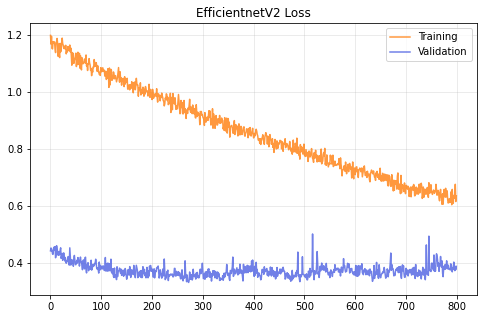

In [38]:
# Plot the accuracy
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

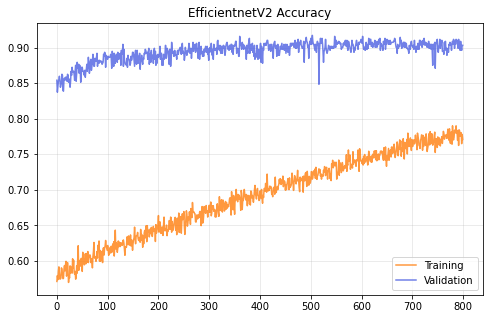

In [39]:
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Accuracy')
plt.legend(loc='lower right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
# Plot the accuracy
plt.figure(figsize=(8,5))
plt.plot(re_history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(re_history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Loss')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(re_history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(re_history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.title(mode + ' Accuracy')
plt.legend(loc='upper right')
plt.grid(alpha=.3)
plt.show()

# Model evaluation
For a better evaluation, we compute the validation F1 scores of the 8 classes locally.

In [40]:
from PIL import Image
import os
from albumentations import *
import albumentations as alb

class PlantDataset():
    """The class PlantDataset loads the data and executes the pre-processing operations on it"""

    def __init__(self, path):
        images = self.load_images(path)
        self.images, self.labels, _,_ = self.split_images(images, 0)
        #self.images,self.labels=self.augment_images()

    @staticmethod
    def split_images(images, rate):
        train_data = []
        train_labels = []
        test_data = []
        test_labels = []
        for k in images.keys():
            n = int(len(images[k]) * rate)
            train_data += images[k][n:]
            test_data += images[k][:n]
            train_labels += [k] * (len(images[k]) - n)
            test_labels += [k] * (n)

        return train_data, train_labels, test_data, test_labels
    def augment_images(self):
        image_augmented=[]
        labels=[]
        for i,l in zip(self.images,self.labels):

            image_augmented.append(i)
            labels.append(l)

            image_augmented.append(tf.image.flip_left_right(i))
            labels.append(l)

            image_augmented.append(tf.image.flip_up_down(i))
            labels.append(l)

            image_augmented.append(tf.image.transpose(i))
            labels.append(l)


        return image_augmented,labels

    def get_images(self):
        return self.images, self.labels

    @staticmethod
    def load_images(image_path):
        """This method loads the images from the given path"""
        images = {}
        for i, file in enumerate(os.listdir(image_path)):
            for img in os.listdir(os.path.join(image_path, file)):
                path = os.path.join(image_path, file, img)
                image = Image.open(path)
                if i in images:
                    images[i].append(np.asarray(image))
                else:
                    images[i]=[np.asarray(image)]

        return images

    def __len__(self):
        return len(self.images)

ds=PlantDataset(validation_dir)
ds.__len__()

713

In [41]:
def predict(model, X):

    X = np.reshape(X, (-1, 96, 96, 3))
    assert X.ndim == 4

#     X = X/255.

    X = tf.keras.applications.efficientnet_v2.preprocess_input(X)
    
#     prediction = model.predict(X)
    
    predicts = []
    
    fs = [tf.image.flip_left_right, tf.image.flip_up_down, tf.image.transpose]
    for f in fs:
        data = f(X)
        pred = model.predict(data)
        predicts.append(pred)
    
    prediction = model.predict(X)
    
    for j in range(0, len(predicts)):
        prediction += predicts[j]
    prediction = prediction / (1 + len(predicts))
    
    output = tf.argmax(prediction, axis=-1)
    return output



def accuracy(ds, model,step=100):
    """Compute the accuracy rate on the given dataset with the input model"""

    num_correct = 0
    data,target=ds.get_images()
    n =ds.__len__()
    tp=[0]*8
    tn=[0]*8
    fp=[0]*8
    fn=[0]*8
    for i in range(0,n//step+1):
        x=data[i*step:min(n,(i+1)*step)]
        y=target[i*step:min(n,(i+1)*step)]
        output = predict(model,x)
        c=np.array(y==output)
        num_correct += sum(c)
        for a,b in zip(y,output):
            if a==b:
                tp[a]+=1
                for i in range(8):
                    if i==a:
                        continue
                    tn[i]+=1
            else:
                fp[b]+=1
                fn[a]+=1
                for i in range(8):
                    if i==a or i==b:
                        continue
                    tn[i]+=1


    print(num_correct/ds.__len__())
    for i in range(8):
        precision=tp[i]/(tp[i]+fp[i]+1e-3)
        recall=tp[i]/(tp[i]+fn[i]+1e-3)
        print("class:",i,"f1 score:",2 * precision * recall / (precision + recall + 1e-3),"precision:",precision,"recall:",recall)


In [42]:
os.getcwd()

'C:\\Users\\zheng\\Documents\\Uni\\Magistrale\\ANNDL\\22-23\\Homework1\\Env'

In [43]:
print(ds.__len__())
for n in [504, 361, 318, 317, 227]:
    print(n)
    newmodel = tfk.models.load_model(
        "experiments/EfficientnetV2B0_Nov22_23-39-14"+"/base_ckpts/cp_"+str(n)+".ckpt",
        custom_objects={"categorical_focal_loss": categorical_focal_loss}
    )
    accuracy(ds,newmodel)

713
504
1/1 [==============================] - 0s 24ms/step
0.9186535764375876
class: 0 f1 score: 0.6566281300219172 precision: 0.7187275397643824 recall: 0.6052472303360438
class: 1 f1 score: 0.9277213376158968 precision: 0.9509710689110891 recall: 0.9065335837982822
class: 2 f1 score: 0.952321862112121 precision: 0.9265970036972138 recall: 0.9805730041455908
class: 3 f1 score: 0.9277211546704807 precision: 0.9150857067386157 recall: 0.9417384297239833
class: 4 f1 score: 0.9360774579779928 precision: 0.9795818410016224 recall: 0.8971878767488154
class: 5 f1 score: 0.954024280579659 precision: 0.9767214715936839 recall: 0.9333125930534878
class: 6 f1 score: 0.9501648745839977 precision: 0.9217311153816053 recall: 0.9814723937741316
class: 7 f1 score: 0.885206540217216 precision: 0.861103137933908 recall: 0.9117557671003225
361
1/1 [==============================] - 0s 24ms/step
0.9130434782608695
class: 0 f1 score: 0.7037083461141809 precision: 0.7575528014302597 recall: 0.657877424278

# Model saving
The model is saved and it can be reloaded if necessary.

In [ ]:
# Save the model
model.save(mode)

INFO:tensorflow:Assets written to: Baseline/assets


INFO:tensorflow:Assets written to: Baseline/assets
